# Acompanhamento do Capítulo 2 do Livro _Hands On Machine Learning_
do autor Aurélien Géron

## 1. Adquirindo os dados:

In [1]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

In [2]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
housing['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [5]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

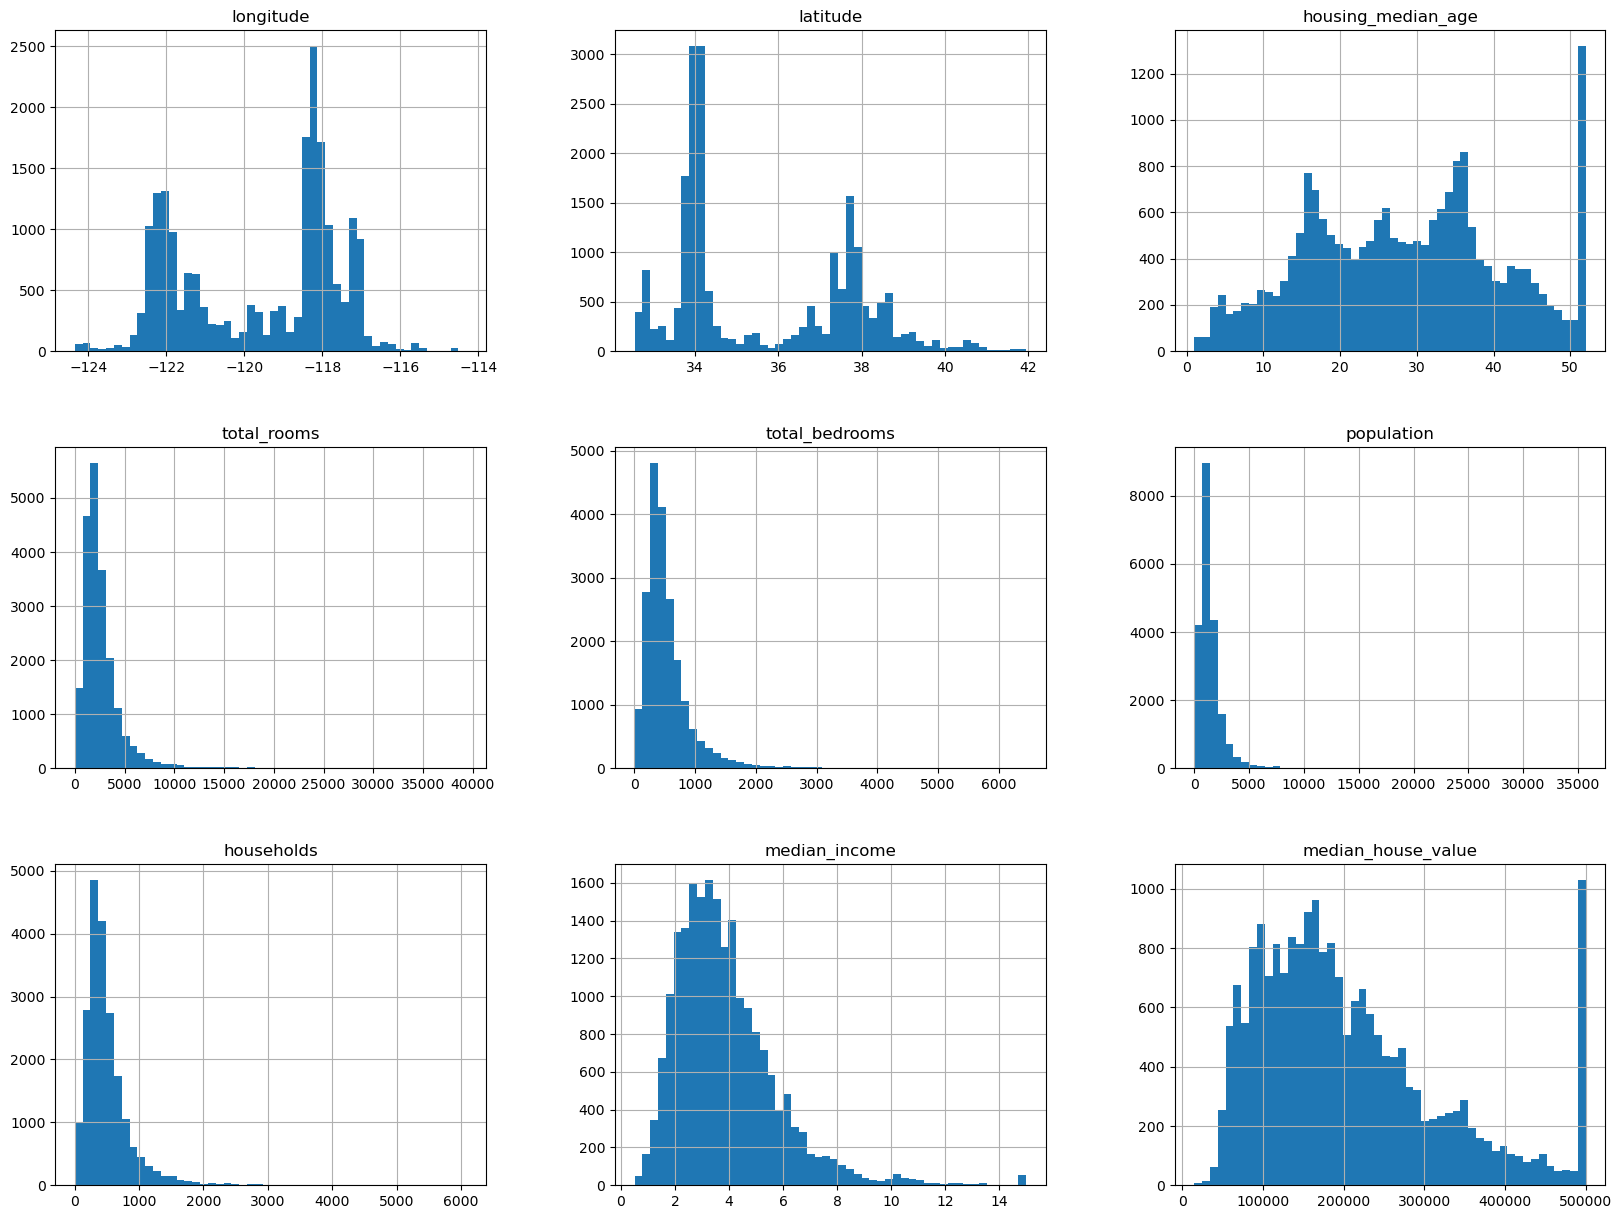

In [6]:
housing.hist(bins=50, figsize=(20,15))

## 2. Criando um conjunto de testes

Utilizaremos 20% da base para testar o algoritmo. Contudo, a função abaixo não é perfeita, porque, vez após vez, o algoritmo será treinado com frações diferentes e aleatórias da base, podendo gerar Overfitting.

In [7]:
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(test_ratio * len(data))
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(housing, 0.2)
print("\033[94mtrain set length :", len(train_set), "\ntest set length  :", len(test_set), "\033[m")

train set length : 16512 
test set length  : 4128 


##### Façamos diferente:
Vamos utilizar o identificador de cada instância para decidir se a instância deve ou não entrar no conjunto de teste. Por exemplo, selecionar toda instância abaixo de 20% do tamanho da base de dados:

In [8]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

##### Referência:
Para entender o CRC de 32 bits, visite: https://pt.wikipedia.org/wiki/CRC

In [9]:
housing_with_id = housing.reset_index() # adiciona uma coluna 'index', um id para cada instância
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")
print("\033[94mtrain set length :", len(train_set), "\ntest set length  :", len(test_set), "\033[m")

train set length : 16512 
test set length  : 4128 


Também poderíamos usar a latitude e longitude como id:

In [10]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")
print("\033[94mtrain set length :", len(train_set), "\ntest set length  :", len(test_set), "\033[m")

train set length : 16322 
test set length  : 4318 


Graças à Deus, o módulo sklearn tem uma função built-in que reduz o trabalho de dividir os dados em teste e treinamento:

In [11]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

##### Nota:
42 é apenas um número mágico e convencional para definir uma seed random. Não há nada de especial nele. :)

##### Porém...
Uma amostragem estratificada pode evitar viés, diferente de uma amostragem aleatória. Assim, vamos pegar a renda média de cada instância, que é um atributo numérico contínuo, e vamos transformar em um atributo categórico dividindo-o em 5 estratos. Veja como fazer isso usando pandas.cut():

<Axes: >

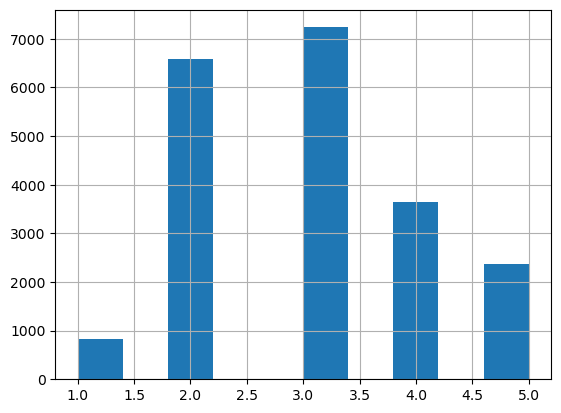

In [12]:
housing["income_category"] = pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1,2,3,4,5])
housing["income_category"].hist()

Veja que a label **1** vai de 0 a 1.5, a **2** de 1.5 a 3.0, ... e a **5** de 6.0 até infinito positivo. Agora, vamos fazer a divisão da base de dados com amostragem estratificada:

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_category"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

print("\033[1mProporções dos estratos:\n\033[m\033[94m")
print(strat_test_set["income_category"].value_counts() / len(strat_test_set))
print("\033[m")

Proporções dos estratos:

income_category
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64



Depois de estratificar e dividir os dois conjuntos, não precisamos mais da coluna **income_category**. Se ela, daqui em diante, só vai atrapalhar, iremos removê-la (_drop it_). Assim:

In [14]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_category", axis=1, inplace=True)

## 3. Exploração e visualização dos dados:
Vamos fazer uma cópia do conjunto dew treinamento para poder brincar com os dados, sem perder os originais:

<Axes: xlabel='longitude', ylabel='latitude'>

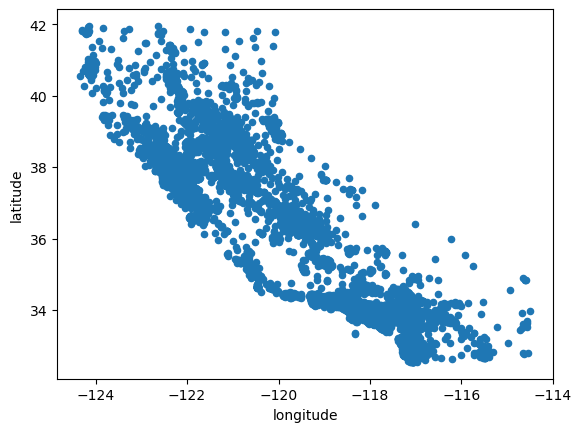

In [15]:
housing = strat_train_set.copy()
housing.plot(kind="scatter", x="longitude", y="latitude")

Mude o parâmetro **alpha** para ter uma visualização melhor dos dados concentrados.

---

### alpha = 0.1

<Axes: xlabel='longitude', ylabel='latitude'>

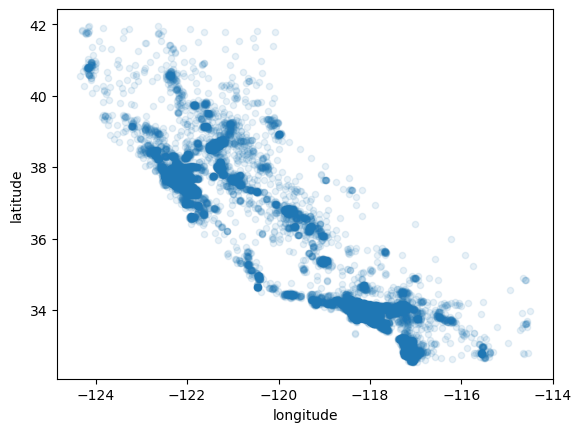

In [16]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

---

### alpha = 0.5

<Axes: xlabel='longitude', ylabel='latitude'>

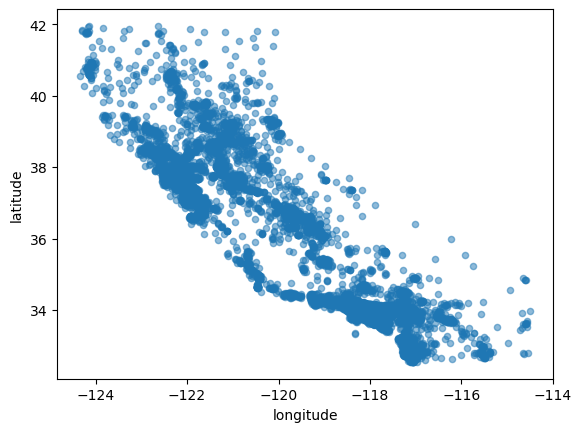

In [17]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.5)

---

### alpha = 1 (default)

<Axes: xlabel='longitude', ylabel='latitude'>

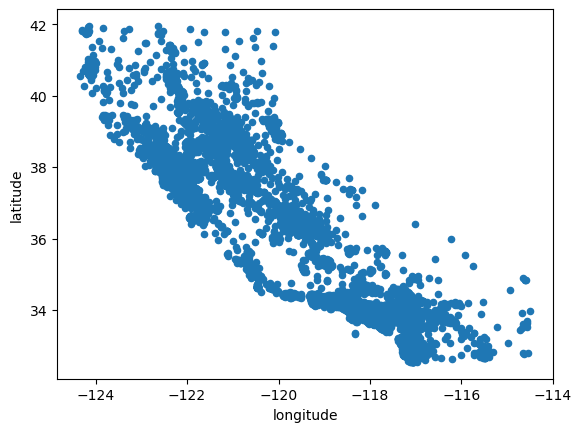

In [18]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=1)

---


### Usando raio de círculos:

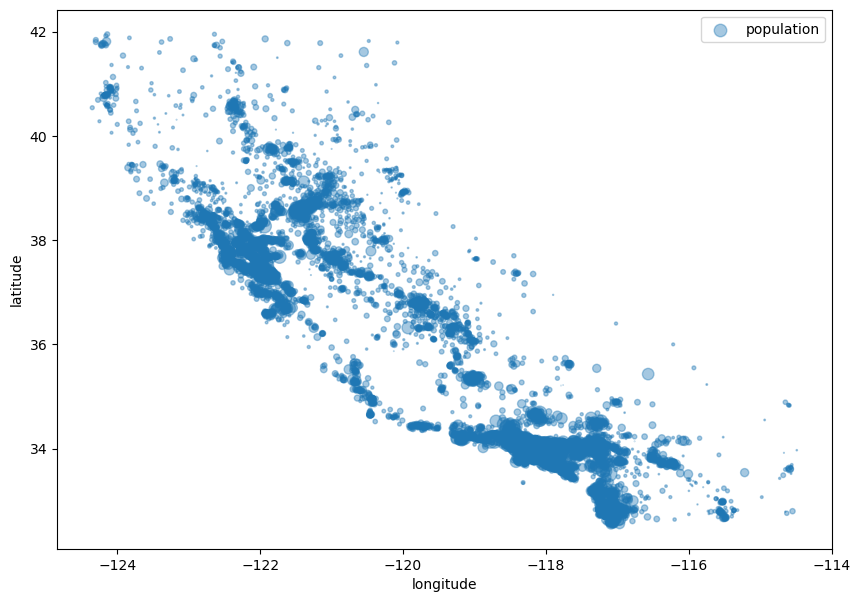

In [19]:
import matplotlib.pyplot as plt

housing.plot(
    kind = 'scatter',
    x = 'longitude',
    y = 'latitude',
    alpha = 0.4,
    s = housing['population']/100, # raio dos círculos = população
    label = 'population',
    figsize = (10, 7), # permite definir não só o tamanho, mas a proporção x/y
)

plt.legend()

### Usando escala de cores

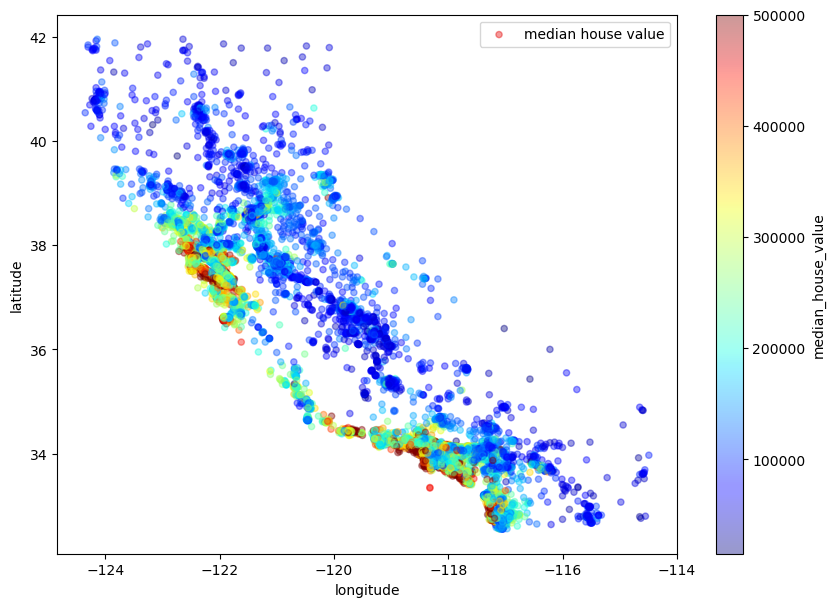

In [20]:
import matplotlib.pyplot as plt

housing.plot(
    kind = 'scatter',
    x = 'longitude',
    y = 'latitude',
    alpha = 0.4,
    label = 'median house value',
    figsize = (10, 7), # permite definir não só o tamanho, mas a proporção x/y
    c = 'median_house_value', # escala cores = preço médio das casas
    cmap = plt.get_cmap('jet'), # mapa de cores pré-definido
    colorbar = True # adiciona a barra de cores à direita
)

plt.legend()

### Usando ambos:

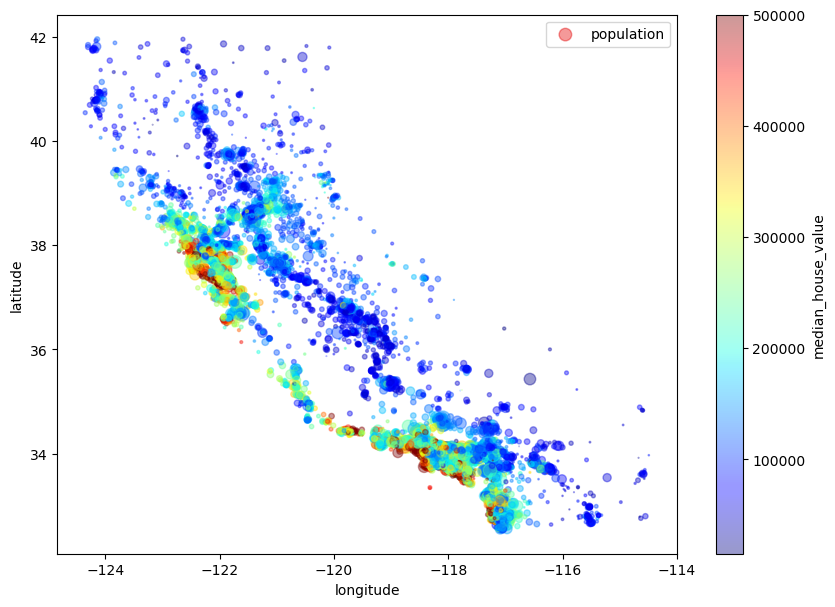

In [21]:
import matplotlib.pyplot as plt

housing.plot(
    kind = 'scatter',
    x = 'longitude',
    y = 'latitude',
    alpha = 0.4,
    s = housing['population']/100, # raio dos círculos = população
    label = 'population',
    figsize = (10, 7), # permite definir não só o tamanho, mas a proporção x/y
    c = 'median_house_value', # escala cores = preço médio das casas
    cmap = plt.get_cmap('jet'), # mapa de cores pré-definido
    colorbar = True # adiciona a barra de cores à direita
)

plt.legend()

## 3.1. Coeficiente de Correlação Padrão (r de _Pearson_)
Calcula quanto cada atributo está correlacionado linearmente com os demais. Ou seja, quando um sobe, outro sobe (correlação linear **positiva**, ou _diretamente proporcional_); ou quando um sobe, outro desce (correlação linear **negativa**, ou _inversamente proporcional_); ou quando um sobe, o outro permanece constante (não há correlação). Abaixo está a matrix completa

In [22]:
housing_numeric = housing.drop('ocean_proximity', axis=1, inplace=False)
correlation_matrix = housing_numeric.corr()
print('\033[94m')
print(correlation_matrix)
print('\033[m')


                    longitude  latitude  housing_median_age  total_rooms  \
longitude            1.000000 -0.924213           -0.102937     0.044558   
latitude            -0.924213  1.000000            0.005692    -0.036753   
housing_median_age  -0.102937  0.005692            1.000000    -0.361710   
total_rooms          0.044558 -0.036753           -0.361710     1.000000   
total_bedrooms       0.068210 -0.066391           -0.317978     0.930076   
population           0.104236 -0.115677           -0.301906     0.863967   
households           0.054261 -0.071604           -0.300075     0.916143   
median_income       -0.016542 -0.078137           -0.127043     0.197720   
median_house_value  -0.050859 -0.139584            0.102175     0.137455   

                    total_bedrooms  population  households  median_income  \
longitude                 0.068210    0.104236    0.054261      -0.016542   
latitude                 -0.066391   -0.115677   -0.071604      -0.078137   
housing

Vamos ver como os atributos estão relacionados com o Preço Médio das Casas:

In [23]:
print('\033[1mLinear Correlation with \033[4mmedian_house_value:\033[m')
correlation_matrix['median_house_value'].sort_values(ascending=False)

Linear Correlation with median_house_value:


median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

Veja que há uma alta correlação linear entre o Valor Médio das Casas e a Renda Média, mas quase não há correlação entre aquele e a concentração de população:

<Axes: xlabel='population', ylabel='median_house_value'>

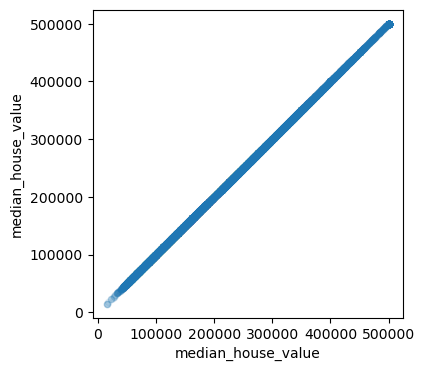

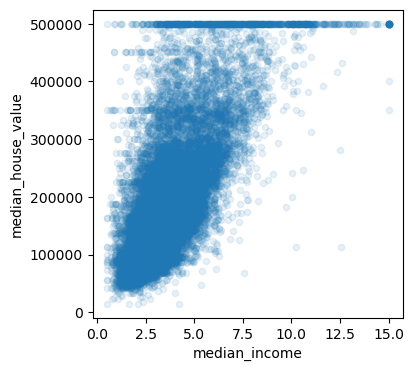

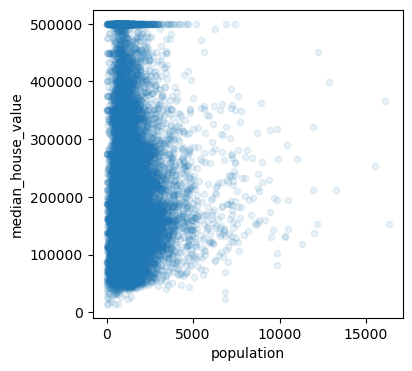

In [24]:
# perfeitamente linear:
housing_numeric.plot(kind='scatter', x='median_house_value', y='median_house_value', alpha=0.1, figsize=(4,4))

# levemente linear
housing_numeric.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1, figsize=(4,4))

# nada linear, dados espalhados
housing_numeric.plot(kind='scatter', x='population', y='median_house_value', alpha=0.1, figsize=(4,4))

Podemos usar o método **scatter_matrix** para obter outra espécie de correlação, uma não linear:

array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

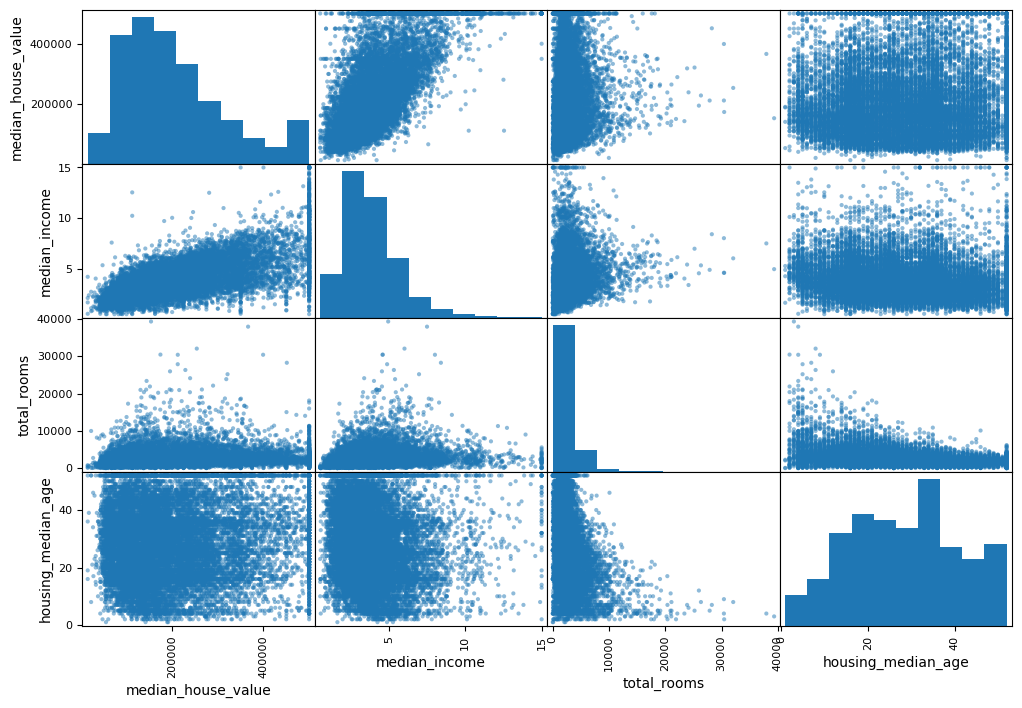

In [25]:
from pandas.plotting import scatter_matrix

relevant_attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']

scatter_matrix(housing[relevant_attributes], figsize=(12,8))
# a diagonal principal é um histograma do atributo, e não a correlação de um atributo consigo mesmo (reta perfeita)

## 3.2. Combinação de Atributos
Às vezes, atributos isolados não são muito úteis. Se eu quero verificar algum índice de saúde da população, por exemplo, a altura e o peso sozinhos podem não ser tão significativos quanto o IMC, que é uma combinação desses dois atributos. Vejamos algumas combinações interessantes abaixo:

In [26]:
# número de cômodos por famílias
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']

# número de quartos por cômodo
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']

# número de população por domicílio
housing['population_per_household'] = housing['population'] / housing['households']

correlation_matrix = housing.drop('ocean_proximity', axis=1, inplace=False).corr()

print('\033[1mLinear Correlation with \033[4mmedian_house_value:\033[m')
correlation_matrix["median_house_value"].sort_values(ascending=False)

Linear Correlation with median_house_value:


median_house_value          1.000000
median_income               0.688380
rooms_per_household         0.143663
total_rooms                 0.137455
housing_median_age          0.102175
households                  0.071426
total_bedrooms              0.054635
population                 -0.020153
population_per_household   -0.038224
longitude                  -0.050859
latitude                   -0.139584
bedrooms_per_room          -0.256397
Name: median_house_value, dtype: float64

Note que os atributos mais correlacionados com _median_house_value_ (positiva ou negativamente) são, em ordem:
```
1º    median_income               0.688380
2º    bedrooms_per_room          -0.256397
3º    rooms_per_household         0.143663
4º    latitude                   -0.139584
5º    total_rooms                 0.137455
```

## 4. Preparando os Dados:
Vamos transformar e limpar os dados. Para isso, separemos as labels do dataset dos previsores:

In [27]:
housing = strat_train_set.drop("median_house_value", axis=1) # inplace = False (default)
housing_labels = strat_train_set["median_house_value"].copy() # apenas as labels

Note que o atributo `total_bedrooms` possui valores nulos:

In [28]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 13096 to 19888
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16344 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


##### Há algumas abordagens para tratar isso:

1. Excluir apenas as características nulas:
```
    housing.dropna(subset=["total_bedrooms"])
```
---
2. Excluir o atributo todo:
```
    housing.drop("total_bedrooms", axis=1)
```
---
3. Substituir os valores nulos por algum outro valor válido:
```
    median = housing["total_bedrooms"].median()
    housing["total_bedrooms"].fillna(median, inplace=True)
```

### 4.1. SimpleImputer
A classe SimpleImputer da Scikit-Learn se encarrega dos valores ausentes para nós. `fit()` fará o `imputer` calcular as médias e armazenar em `statistics_`

In [29]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')

housing_only_num = housing.drop('ocean_proximity', axis=1)
imputer.fit(housing_only_num)

SimpleImputer(strategy='median')

In [30]:
print(imputer.statistics_)
print(housing_only_num.median().values)

[-118.51     34.26     29.     2125.      434.     1167.      408.
    3.5385]
[-118.51     34.26     29.     2125.      434.     1167.      408.
    3.5385]


`transform` irá substituir os valores vazios conforme as médias calculadas:

In [31]:
X = imputer.transform(housing_only_num)
housing_transformed = pd.DataFrame(X, 
                                   columns=housing_only_num.columns, 
                                   index=housing_only_num.index
                                  )

_nota: o método `fit_transform()` é equivalente a chamar `fit()` e depois `transform()`, exceto por ser mais otimizado_

 ### 4.2. Manipulando atributos categóricos:

In [32]:
print("\033[1mnota: dataset['column'] é diferente de dataset[['column']]:\033[m\033[94m")
temp = housing['ocean_proximity']
print(' ', "dataset['column']   :", type(housing['ocean_proximity']))
del temp
print(' ', "dataset[['column']] :", type(housing[['ocean_proximity']]), '\033[m')

# ---

housing_only_cat = housing[['ocean_proximity']]
housing_only_cat.head(10)

nota: dataset['column'] é diferente de dataset[['column']]:
  dataset['column']   : <class 'pandas.core.series.Series'>
  dataset[['column']] : <class 'pandas.core.frame.DataFrame'> 


,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY
18031,<1H OCEAN
6753,<1H OCEAN


Note que os valores de `ocean_proximity` não são aleatórios: há um número limitado de possíveis valores textuais para o atributo. Assim, esse é um **atributo categórico**, e pode ser transformado em um atributo numérico:

In [33]:
from sklearn.preprocessing import OrdinalEncoder # vamos fazer um encode que faz cada categoria corresponder a um número

ordinal_encoder = OrdinalEncoder()

# fit_transform(): ou seja, OrdinalEncoder é um Estimador e um Transformador
housing_cat_encoded = ordinal_encoder.fit_transform(housing_only_cat)

housing_cat_encoded[:10]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.],
       [0.],
       [0.]])

Deu certo: cada categoria corresponde a um valor de 0 a 4. Para saber qual categoria corresponde a qual valor, use:

In [34]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

Também dá pra formatar bonitinho:

In [35]:
i = 0
for cat in ordinal_encoder.categories_[0]: # índice [0] necessário, pois poderiam ter sido codificadas mais colunas de housing
    print(i, ': ', cat)
    i += 1

0 :  <1H OCEAN
1 :  INLAND
2 :  ISLAND
3 :  NEAR BAY
4 :  NEAR OCEAN


O problema com esse tipo de encode é que os algoritmos entendem que há mais proximidade, por exemplo, entre 0 e 1 do que entre 0 e 4. No nosso caso, entretando, isso não é verdade. Por isso, há outra forma de encode: *one-hot encode*. Esse encode faz com que cada categoria se torne uma coluna nova, com valores boolenaos (0 ou 1). Assim, sempre haverá 1 coluna com valor `1`  e *n-1* colunas com valor `0`.

In [36]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()

housing_cat_1hot = cat_encoder.fit_transform(housing_only_cat)

In [37]:
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [38]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

`housing_cat_1hot` foi armazenada como uma *matriz esparsa*, o que significa que, ao invés de existir uma matriz 2D com um monte de zeros e alguns 'uns', o que seria desperdício de espaço, a matriz apenas indica em qual coluna está o valor não nulo. Apesar disso, `housing_cat_1hot` ainda pode sre manipulado como uma matriz 2D

### 4.3 Customização de Transformadores
A Scikit-Learn é fexível no que tange à criação e customização de transformadores. Basta criar uma classe com os métodos `fit` e `transform`:

In [39]:
from sklearn.base import BaseEstimator, TransformerMixin # classes base a serem customizadas

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_rooms=True): # facilita o teste de diferentes combinações, na execução dos algoritmos
        self.add_bedrooms_per_rooms = add_bedrooms_per_rooms
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        
        if self.add_bedrooms_per_rooms:
            bedrooms_per_rooms =  X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_rooms]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_rooms=False)
housing_extra_attribs = attr_adder.transform(housing.values)

### 4.4. Escalonamento de Características
Geralmente, algoritmos de Aprendizado de Máquina podem não funcionar bem com dados em escalas muito diferentes. Por exemplo, dados em que um atributo varia de 0 a 10 e outro varia de 0 a 10000. Há duas formas de consertar isso:
```
    1. Escalonamento min-max (ou normalização)
    2. Padronização
```
A normaização reescalona os dados para que fiquem no intervalo 0-1. Para tal, subtrai-se o Valor Mínimo de cada instância e depois divide-se pelo Valor Máximo (_y = (x - min) / max_). A Scikit-Learn tem o transformador `MinMaxScaler` para isso, com um parâmetro `feature_range`, para o caso de você querer um intervalo diferente de 0-1.

A padronização subtrai cada valor pelo Valor médio, e então os subtrai pelo Desvio Padrão. Assim, dados padronizados sempre tem média igual a 0. A Scikit-Learn oferece o transformador `StandardScaler` para isso.

### 4.5 Pipelines
Veja: há muitas transformações a serem feitas na ordem correta durante o pré-processamento dos dados. Por isso, a Scikit-Learn possui a classe `Pipeline`, para que uma sequência de transformações seja executa na ordem desejada:

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([ ('imputer', SimpleImputer(strategy='median')),
                          ('attibs_adder', CombinedAttributesAdder()),
                          ('std_scaler', StandardScaler())
                        ])

housing_num_transform = num_pipeline.fit_transform(housing_only_num)

Não seria ótimo se pudéssemos transformar tanto os atributos categóricos quanto os numéricos de uma só vez? Para isso, aSkit-Learn introduziu o `ColumnTransformer` na versão 0.20:

In [41]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_only_num)
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([ ("num", num_pipeline, num_attribs),
                                    ("cat", OneHotEncoder(), cat_attribs)
                                  ])

housing_prepared = full_pipeline.fit_transform(housing)

#### DEU CERTO, SEUS PILANTRA!!!

## 5. Treine um Algoritmo

### 5.1. Regressão Linear
Chegou a hora! Vamos escolher e treinar um algoritmo. Nessa caso, vamos testar a Regressão Linear:

In [42]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

Tá lá! Temos o modelo treinado. Vamos testá-lo em algumas instâncias:

In [43]:
some_data = housing.iloc[:5]           # alguns atributos preditores
some_labels = housing_labels.iloc[:5]  # alguns atributos metas correspondentes

some_data_prepared = full_pipeline.transform(some_data)

In [44]:
print("\033[31mPredictions:", lin_reg.predict(some_data_prepared))
print("\033[94mLabels:", list(some_labels))
print("\033[m")

Predictions: [276608.27419651 333603.0303772  118237.5726011  108255.75159886
 308943.82732346]
Labels: [458300.0, 483800.0, 101700.0, 96100.0, 361800.0]



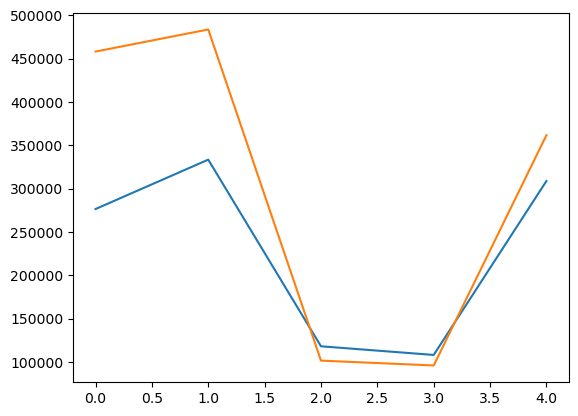

In [45]:
plt.plot([0,1,2,3,4], lin_reg.predict(some_data_prepared))
plt.plot([0,1,2,3,4], some_labels)

Funcionou, apesar das previsões não serem precisas. Vamos calcular a Raiz do Erro Quadrado Médio (RMSE) desse modelo:

In [46]:
from sklearn.metrics import mean_squared_error # MSE

housing_predictions = lin_reg.predict(housing_prepared)
lin_reg_MSE = mean_squared_error(housing_labels, housing_predictions) # real x previsto
lin_reg_RMSE = np.sqrt(lin_reg_MSE)

print('Root Mean Squared Error:\033[91m', lin_reg_RMSE, '\033[m')

Root Mean Squared Error: 67769.12117461127 


Os imóveis variam entre _US 120.000,00_ e _US 265.000,00_. Um erro de _US 67.769,12_ não é muito satisfatório. Antes de mexer no modelo, para ver o que conseguimos com a Regressão Linear, vamos tentar algum modelo um pouco mais complexo.

### 5.2 Regressão de árvore de Decisão


In [47]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [48]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_reg_MSE = mean_squared_error(housing_labels, housing_predictions)
tree_reg_RMSE = np.sqrt(tree_reg_MSE)

print('Root Mean Squared Error:\033[91m', tree_reg_RMSE, '\033[m')

Root Mean Squared Error: 0.0 


Hmmm... (Õ_Õ)

Bem SUS, realmente. Mais provavel do que termos encontrado o modelo perfeito é o modelo ter sobreajustado os dados. Dessa forma, teremos que achar uma outra forma de testar o nosso modelo:

#### Validação Cruzada

_N-Fold Cross Validation_ (ou Validação Cruzada de N Partes) é uma forma de testar modelos. O conjunto de treinamento é dividido em N partes (normalmente, 10 partes) e o algoritmo é treinado N vezes: em cada vez, são utilizadas N-1 partes para treino e uma parte para validação.

In [49]:
from sklearn.model_selection import cross_val_score

# scores no plural, porque será um array com 10 resultados
scores = cross_val_score(tree_reg,                          # modelo
                         housing_prepared,                  # ats. preditores
                         housing_labels,                    # at. meta
                         scoring='neg_mean_squared_error',  # tipo de validação
                         cv=10)                             # número de folds

tree_reg_RMSE = np.sqrt(-scores)

_nota: os recursos de validação preferem uma **função de utilidade** (quanto maior, melhor) do que uma **função de custo** (quanto menor, melhor). Por isso, calculamos os resultados usando o método "**neg** mean squared error", e depois calculamos a raiz de -scores_

In [50]:
def display_scores(scores):
    i=0
    print('Scores:')
    for score in scores:
        i+=1
        print("       %2iº fold  : \033[91m" % i, score, '\033[m')
    print()
    print('           Mean  : \033[91m', scores.mean(), '\033[m')
    print('  Std Variation  : \033[91m', scores.std(), '\033[m')

display_scores(tree_reg_RMSE)

Scores:
        1º fold  :  66997.8654138662 
        2º fold  :  67131.60556355372 
        3º fold  :  68344.41119367888 
        4º fold  :  73237.4502226827 
        5º fold  :  70232.10804477596 
        6º fold  :  69664.49676784452 
        7º fold  :  71802.16973635247 
        8º fold  :  72442.74067650393 
        9º fold  :  69081.03222914183 
       10º fold  :  70653.42348963405 

           Mean  :  69958.73033380343 
  Std Variation  :  2027.269677619896 


Parece que está pior do que a Regressão Linear. Falando nisso, vamos testar a Cross Validation nesse modelo, só pra ter certeza:

In [51]:
lin_reg_scores = cross_val_score(lin_reg,
                        housing_prepared,
                        housing_labels,
                        scoring='neg_mean_squared_error',
                        cv=10)

lin_reg_RMSE = np.sqrt(-lin_reg_scores)
display_scores(lin_reg_RMSE)

Scores:
        1º fold  :  69717.57852026075 
        2º fold  :  66650.2661787054 
        3º fold  :  66488.43193213035 
        4º fold  :  70478.22519838437 
        5º fold  :  66837.93229332467 
        6º fold  :  68220.3109152103 
        7º fold  :  66922.70445332132 
        8º fold  :  69700.47781663998 
        9º fold  :  67122.26131606763 
       10º fold  :  67802.47918508142 

           Mean  :  67994.06678091262 
  Std Variation  :  1394.9377015503235 


### 5.3. Regrssão de Floresta Aleatória
Vamos testar mais um: _Random Forest Regressor_. Esse modelo utiliza a média do resultado da pradeição de várias Árvores de Decisão para gerar um resultado melhor. Esse tipo de modelo é o que chama-se de _aprendizado ensemble_ (ou, "por agrupamento").

In [52]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()

forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor()

In [53]:
forest_reg_scores = cross_val_score(forest_reg,
                                    housing_prepared,
                                    housing_labels,
                                    scoring='neg_mean_squared_error',
                                    cv=10)

forest_reg_RMSE = np.sqrt(-forest_reg_scores)
display_scores(forest_reg_RMSE)

KeyboardInterrupt: 

Opa, um modelo melhor. Mas ainda não está bom, quando o modelo for validado com o `test_set` (conjuto de testes), o erro vai aumentar. Podemos achar algumas saídas:
```
    1. Simplificar o modelo
    2. Restringir o modelo (regularizar)
    3. Obter mais dados de treinamento
```
_Obs.: o ideal, nesse caso, seria testar mais modelos, como SVMs, Redes Neurais, etc. Assim selecionaria-se entre 2 a 5 modelos promissores_

Para salvar um modelo, pode-se usar os módulos `pickle` ou `joblib`. Esse último e mais eficiente em serializar arrays NumPy grandes (tem que instalar com o `pip`):
```
    import joblib
    joblib.dump(my_model, 'my_model.pkl')
```
E depois, para carregar o modelo:
``` 
    my_model_loaded = joblib.load('my_model.pkl')
```

## 6. Aperfeiçoe o modelo:
Um modo de fazer isso seria testar todas as combinações de hiperparâmetros de um modelo. Não precisamos fazer isso na mão, a Scikit-Learn implementa o `GridSearchCV` para isso. Passe todos os hiperparâmetros que você quer testar e ele vai executar todas as combinações possíveis (_grid search_), validando cada resultado com validação cruzada (_cross validation_, ou _CV_):

In [55]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {
        'n_estimators': [3, 10, 30],
        'max_features': [2, 4, 6, 8]
    },
    {
        'bootstrap': [False],
        'n_estimators': [3, 10],
        'max_features': [2, 3, 4]
    }
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg,
                           param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

Nesse caso, estamos pedindo para o algoritmo de grid search testar 3 _n_estimators_ vezes 4 _max_features_, que totalizam $3 * 4 = 12$ combinações diferentes. Depois, testamos $2 * 3 = 6$ combinações diferentes, mas com _bootstrap_ falso, ao invés de verdadeiro (que é o padrão). Estamos usando uma validação cruzada de 5 _folds_, e com isso, cada combinação vai ser testada 5 vezes. Dessa forma, teremos $5 * 6 + 5 * 12 = 30 + 60 = 90$ execuções do algoritmo de _Random Forest_. Pode demorar, mas no final, teremos o melhor resultado e seus respectivos hiperparâmetros, que poderão ser consultados com:

In [57]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

_nota: quando os melhores hiperparâmetros são os maiores/menores valores inseridos, vale a pena testar valores ainda maiores/menores._

In [58]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30)

Isso significa que o melhor estimador pode ser obtido executando:
```
    forest_reg = RandomForestRegressor(max_features=6, n_estimators=30)
```

Também podem ser consultados os outros resultados:

In [64]:
CV_results = grid_search.cv_results_

for mean_score, params in zip(CV_results['mean_test_score'], CV_results['params']):
    print('Params  : ', params)
    print('  RMSE  : \033[91m', np.sqrt(-mean_score), '\033[m')
    print()


Params  :  {'max_features': 2, 'n_estimators': 3}
  RMSE  :  64621.89748739271 

Params  :  {'max_features': 2, 'n_estimators': 10}
  RMSE  :  55170.40914382003 

Params  :  {'max_features': 2, 'n_estimators': 30}
  RMSE  :  52427.05265509341 

Params  :  {'max_features': 4, 'n_estimators': 3}
  RMSE  :  59632.21953377613 

Params  :  {'max_features': 4, 'n_estimators': 10}
  RMSE  :  52571.27921569632 

Params  :  {'max_features': 4, 'n_estimators': 30}
  RMSE  :  49949.95871533382 

Params  :  {'max_features': 6, 'n_estimators': 3}
  RMSE  :  58032.49769107405 

Params  :  {'max_features': 6, 'n_estimators': 10}
  RMSE  :  51948.139717432554 

Params  :  {'max_features': 6, 'n_estimators': 30}
  RMSE  :  49786.356602031454 

Params  :  {'max_features': 8, 'n_estimators': 3}
  RMSE  :  58166.21875996568 

Params  :  {'max_features': 8, 'n_estimators': 10}
  RMSE  :  51753.861022790785 

Params  :  {'max_features': 8, 'n_estimators': 30}
  RMSE  :  49986.336873606706 

Params  :  {'boo

Existem outros métodos de testar hiperparâmteros, como por exemplo:

##### Randomized Search:
Dado um número máximo N de iterações que é permitido ao algoritmo executar, ele testará combinações aleatórias de hiperparâmetros. Isso é útil quando você tem uma gama enorme de hperparâmetros para testar.

##### Métodos Ensemble:
Consiste em juntar algoritmos, assim como o Random Forest faz com Decision Trees.

Enfim, existem vários métodos.

## 7. Dê uma bizoiada nos resultados
Você pode obter informações úteis sobre como melhorar seu modelo dando uma olhada em como ele funciona. Por exemplo, analisar a...

### Importância dos Atributos

In [67]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances # diz a importância de cada atributo para realizar predições precisas

array([7.96795185e-02, 6.52354669e-02, 4.28167223e-02, 1.70294499e-02,
       1.62845129e-02, 1.70645719e-02, 1.56552567e-02, 3.20334307e-01,
       6.93966729e-02, 1.09789128e-01, 6.83874833e-02, 1.17998566e-02,
       1.50297992e-01, 2.40014478e-04, 5.66741177e-03, 1.03216354e-02])

Vamos exibir essas métricas junto com seus respectivos parâmetros:

In [75]:
extra_attribs = ['rooms_per_household', 'population_per_household', 'bedrooms_per_household']

cat_encoder = full_pipeline.named_transformers_['cat']
cat_one_hot_attribs = list(cat_encoder.categories_[0])

attributes = num_attribs + extra_attribs + cat_one_hot_attribs

for importance, attribute in sorted(zip(feature_importances, attributes), reverse=True):
    print('%.5f  :  %s' % (importance, attribute))

0.32033  :  median_income
0.15030  :  INLAND
0.10979  :  population_per_household
0.07968  :  longitude
0.06940  :  rooms_per_household
0.06839  :  bedrooms_per_household
0.06524  :  latitude
0.04282  :  housing_median_age
0.01706  :  population
0.01703  :  total_rooms
0.01628  :  total_bedrooms
0.01566  :  households
0.01180  :  <1H OCEAN
0.01032  :  NEAR OCEAN
0.00567  :  NEAR BAY
0.00024  :  ISLAND


Com essas informações, você pode tomar decisões como descartar características inúteis, agrupar características, limpar outliers, etc.

## 8. Avalie o Sistema com o Conjunto de Testes
Agora é só colocar todo o conjunto de teste no modelo, excluindo as labels, claro, e comparando as previsões com as labels.

**_CUIDADO! Use `transform()` com o conjunto de teste, mas nunca `fit()`!_**

In [77]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop('median_house_value', axis=1)  # o X que será inserido no modelo
Y_test = strat_test_set['median_house_value'].copy()        # o Y = f(X) que é o rótulo real do dado

X_test_prepared = full_pipeline.transform(X_test)  # conjunto de testes passa pelas transformações necessárias

final_predictions = final_model.predict(X_test_prepared)

final_MSE = mean_squared_error(Y_test, final_predictions)

final_RMSE = np.sqrt(final_MSE)

In [79]:
print('Root Mean Squared Error:\033[91m', final_RMSE, '\033[m')

Root Mean Squared Error: 49884.251582751625 


Para ter uma noção do que esse erro significa, calcularemos um intervalo de confiança de 95% usando `scipy`:

In [88]:
from scipy import stats

confidence = 0.95

squared_errors = (final_predictions - Y_test)**2

np.sqrt(
    stats.t.interval(
        confidence,
        len(squared_errors)-1,
        loc = squared_errors.mean(),
        scale = stats.sem(squared_errors)
    )
)

array([47544.16355246, 52119.37858455])

Parabéns! Agora mantenha seu modelo, monitore-o e faça upgrades sempre que necessário.